In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import numpy as np
import tqdm
import random

from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.transforms as transforms
from torchvision.transforms import v2
from torchvision.models import *

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

assert True == torch.cuda.is_available()

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [ ]:
# files = [file for file in os.listdir("test")]

# means = [0,0,0]
# vars = [0,0,0]

# for i in tqdm.tqdm(range(len(files))):
#     file = files[i]
#     img = torchvision.io.read_image(f"test/{file}").to(torch.float).to(device)
#     for j in range(3):
#         means[j] += img[j].mean()
        

In [3]:
class ImageDataset(Dataset):
    def __init__(self, X, Y, train = True):
        self.X = X
        self.Y = Y
        self.train = train

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, item):
        normalize = v2.Normalize((128, 128, 128), (128, 128, 128))
        augmentations = transforms.Compose([
            v2.RandomHorizontalFlip(),
            # v2.RandomAutocontrast(),
            # v2.RandomSolarize(0.4),
            transforms.RandomApply([v2.RandomAffine(degrees=0, translate=(1/8,1/8))], p=0.6),
            # v2.RandomEqualize(0.5),
            # v2.RandomPosterize(16),
            # v2.RandomGrayscale(0.3),
            # v2.RandomPhotometricDistort(saturation=[1, 1.5], hue = [0,0], brightness=[0.875, 1.125], contrast=[0.9,1.1], p = 0.3),
            # v2.ColorJitter(saturation=[1, 1], hue = 0, brightness=[1, 1], contrast=[0.9,1.1])
        ])
        img = torchvision.io.read_image(f"trainval/{self.X[item]}").to(torch.float).to(device)
        img = normalize(img)
        if self.train:
            img = augmentations(img)
        return img, self.Y[item]

data = pd.read_csv("labels.csv")
X_train, X_val, y_train, y_val = train_test_split(data["Id"], data["Category"], test_size=0.2, random_state=42, shuffle=True)

# X_train = X_train.reset_index()["Id"]
# y_train = y_train.reset_index()["Category"]
# X_val = X_val.reset_index()["Id"]
# y_val = y_val.reset_index()["Category"]

train_dataset = ImageDataset(X_train.to_list(), y_train.to_list())
val_dataset = ImageDataset(X_val.to_list(), y_val.to_list(), False)

In [4]:
train_loader = DataLoader(train_dataset, 32, True)
val_loader = DataLoader(val_dataset, 32, True)

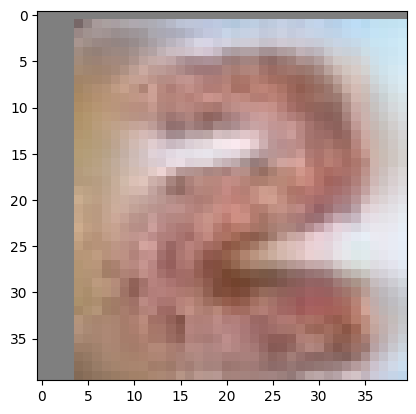

torch.Size([3, 40, 40])


In [5]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.to("cpu").numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    print(img.shape)

imshow(train_dataset[2][0])


In [6]:
# for data, target in train_loader:
#     print(data)
#     print(target)
#     break

In [7]:
@torch.no_grad()
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    criterion = F.cross_entropy
    
    for data, target in tqdm.tqdm(loader):

        data = data.to(device)  # images: batch_size x num_channels x height x width
        target = target.to(device)  # labels: batch_size

        logits = model(data)  # logits: batch_size x num_classes
        loss = criterion(logits, target)
    
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / len(target)

        acc_log.append(acc.item()) 
        
    return torch.tensor(loss_log).mean(), torch.tensor(acc_log).mean()

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    criterion = F.cross_entropy
    
    for data, target in tqdm.tqdm(train_loader):
        
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)  # use this loss for any training statistics
        loss.backward()
        optimizer.step()
        
        loss_log.append(loss.item())
        
        acc = (logits.argmax(dim=1) == target).sum() / len(target)
        
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)
        if scheduler is not None:
            print(f"Epoch {epoch + 1} | lr={scheduler.get_last_lr()[0]}")
        else:
            print(f"Epoch {epoch + 1}")
        print(f" train loss: {torch.tensor(train_loss).mean()}, train acc: {torch.tensor(train_acc).mean()}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")

        torch.save(model, "model.pth")
        
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [8]:
net = efficientnet_v2_s(num_classes=200)

net.features[0][0].stride = (1, 1)
net.features[2][0].block[0][0].stride = (1, 1)
# net.features[3][0].block[0][0].stride = (1, 1)

net.classifier[0].p = 0.6

# print(net)

In [9]:
# model = efficientnet_v2_s(num_classes=200)
# rand_input = torch.randn(1,3,40,40)
# model(rand_input).shape

# torch.onnx.export(model, rand_input, "efficient_net.onnx")

# !netron efficient_net.onnx

In [10]:
net = net.to(device)

Training

In [11]:
torch.manual_seed(1984)
random.seed(1984)
np.random.seed(1984)
torch.cuda.manual_seed(1984)
# torch.backends.cudnn.enabled=False
torch.backends.cudnn.deterministic = True

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4, nesterov=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 30)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 30, train_loader, val_loader, scheduler)

100%|██████████| 625/625 [00:26<00:00, 23.89it/s]


Epoch 1 | lr=0.01
 train loss: 5.132774829864502, train acc: 0.017812499776482582
 val loss: 4.807789325714111, val acc: 0.03739999979734421



100%|██████████| 625/625 [00:24<00:00, 25.51it/s]


Epoch 2 | lr=0.009972609476841367
 train loss: 4.736661911010742, train acc: 0.04600000008940697
 val loss: 4.463888168334961, val acc: 0.07329999655485153



100%|██████████| 625/625 [00:24<00:00, 25.90it/s]


Epoch 3 | lr=0.009890738003669028
 train loss: 4.450878143310547, train acc: 0.07536250352859497
 val loss: 4.126889228820801, val acc: 0.10894999653100967



100%|██████████| 625/625 [00:26<00:00, 24.03it/s]


Epoch 4 | lr=0.009755282581475769
 train loss: 4.132978439331055, train acc: 0.1149125024676323
 val loss: 3.77545428276062, val acc: 0.16019999980926514



100%|██████████| 625/625 [00:24<00:00, 25.32it/s]


Epoch 5 | lr=0.009567727288213004
 train loss: 3.849635601043701, train acc: 0.15497499704360962
 val loss: 3.554142951965332, val acc: 0.19740000367164612



100%|██████████| 625/625 [00:23<00:00, 26.18it/s]


Epoch 6 | lr=0.009330127018922194
 train loss: 3.634542942047119, train acc: 0.18930000066757202
 val loss: 3.3525679111480713, val acc: 0.23555000126361847



100%|██████████| 625/625 [00:27<00:00, 23.12it/s]


Epoch 7 | lr=0.009045084971874737
 train loss: 3.4415807723999023, train acc: 0.22245000302791595
 val loss: 3.1939992904663086, val acc: 0.26840001344680786



100%|██████████| 625/625 [00:24<00:00, 25.34it/s]


Epoch 8 | lr=0.00871572412738697
 train loss: 3.2838633060455322, train acc: 0.2476624995470047
 val loss: 3.0402541160583496, val acc: 0.29670000076293945



100%|██████████| 625/625 [00:25<00:00, 24.39it/s]


Epoch 9 | lr=0.008345653031794291
 train loss: 3.135331630706787, train acc: 0.27486249804496765
 val loss: 2.93377423286438, val acc: 0.31839999556541443



100%|██████████| 625/625 [00:25<00:00, 24.80it/s]


Epoch 10 | lr=0.007938926261462365
 train loss: 3.014817237854004, train acc: 0.2979249954223633
 val loss: 2.838550090789795, val acc: 0.33410000801086426



100%|██████████| 625/625 [00:30<00:00, 20.22it/s]


Epoch 11 | lr=0.007499999999999999
 train loss: 2.9020087718963623, train acc: 0.31603750586509705
 val loss: 2.7950589656829834, val acc: 0.34779998660087585



100%|██████████| 625/625 [00:24<00:00, 25.38it/s]


Epoch 12 | lr=0.007033683215379001
 train loss: 2.7988383769989014, train acc: 0.33697500824928284
 val loss: 2.701817512512207, val acc: 0.35885000228881836



100%|██████████| 625/625 [00:24<00:00, 25.34it/s]


Epoch 13 | lr=0.0065450849718747366
 train loss: 2.7048187255859375, train acc: 0.3579249978065491
 val loss: 2.661494255065918, val acc: 0.36924999952316284



100%|██████████| 625/625 [00:24<00:00, 25.25it/s]


Epoch 14 | lr=0.006039558454088796
 train loss: 2.6109771728515625, train acc: 0.37575000524520874
 val loss: 2.591627597808838, val acc: 0.3833500146865845



100%|██████████| 625/625 [00:27<00:00, 22.85it/s]


Epoch 15 | lr=0.0055226423163382676
 train loss: 2.5162484645843506, train acc: 0.39515000581741333
 val loss: 2.5450122356414795, val acc: 0.39364999532699585



100%|██████████| 625/625 [00:23<00:00, 26.21it/s]


Epoch 16 | lr=0.005000000000000001
 train loss: 2.4284889698028564, train acc: 0.4117250144481659
 val loss: 2.517078399658203, val acc: 0.40435001254081726



100%|██████████| 625/625 [00:27<00:00, 22.55it/s]


Epoch 17 | lr=0.0044773576836617335
 train loss: 2.337533473968506, train acc: 0.42866250872612
 val loss: 2.4702541828155518, val acc: 0.4126499891281128



100%|██████████| 625/625 [00:26<00:00, 23.59it/s]


Epoch 18 | lr=0.003960441545911203
 train loss: 2.248569965362549, train acc: 0.446212500333786
 val loss: 2.439326286315918, val acc: 0.41659998893737793



100%|██████████| 625/625 [00:24<00:00, 25.82it/s]


Epoch 19 | lr=0.003454915028125263
 train loss: 2.1662240028381348, train acc: 0.4606750011444092
 val loss: 2.428201913833618, val acc: 0.42445001006126404



100%|██████████| 625/625 [00:24<00:00, 25.95it/s]


Epoch 20 | lr=0.0029663167846209993
 train loss: 2.0797786712646484, train acc: 0.4799624979496002
 val loss: 2.394380569458008, val acc: 0.43470001220703125



100%|██████████| 625/625 [00:24<00:00, 25.85it/s]


Epoch 21 | lr=0.0025000000000000014
 train loss: 1.99043869972229, train acc: 0.5006374716758728
 val loss: 2.3727757930755615, val acc: 0.43799999356269836



100%|██████████| 625/625 [00:23<00:00, 26.29it/s]


Epoch 22 | lr=0.002061073738537635
 train loss: 1.8903849124908447, train acc: 0.5203375220298767
 val loss: 2.35131573677063, val acc: 0.4474000036716461



100%|██████████| 625/625 [00:23<00:00, 26.34it/s]


Epoch 23 | lr=0.0016543469682057108
 train loss: 1.8075472116470337, train acc: 0.5389500260353088
 val loss: 2.349888563156128, val acc: 0.4507499933242798



100%|██████████| 625/625 [00:23<00:00, 26.38it/s]


Epoch 24 | lr=0.0012842758726130297
 train loss: 1.716328501701355, train acc: 0.5582000017166138
 val loss: 2.335296154022217, val acc: 0.4542999863624573



100%|██████████| 625/625 [00:24<00:00, 25.78it/s]


Epoch 25 | lr=0.0009549150281252636
 train loss: 1.6324256658554077, train acc: 0.5787374973297119
 val loss: 2.3288097381591797, val acc: 0.46265000104904175



100%|██████████| 625/625 [00:27<00:00, 22.39it/s]


Epoch 26 | lr=0.0006698729810778067
 train loss: 1.5507280826568604, train acc: 0.5963500142097473
 val loss: 2.3345718383789062, val acc: 0.4648999869823456



100%|██████████| 625/625 [00:23<00:00, 26.12it/s]


Epoch 27 | lr=0.00043227271178699527
 train loss: 1.4757764339447021, train acc: 0.6132000088691711
 val loss: 2.3395884037017822, val acc: 0.4643999934196472



100%|██████████| 625/625 [00:29<00:00, 20.89it/s]


Epoch 28 | lr=0.0002447174185242324
 train loss: 1.4246958494186401, train acc: 0.6266375184059143
 val loss: 2.328742027282715, val acc: 0.470550000667572



100%|██████████| 625/625 [00:27<00:00, 22.73it/s]


Epoch 29 | lr=0.00010926199633097158
 train loss: 1.392293095588684, train acc: 0.6321874856948853
 val loss: 2.3257250785827637, val acc: 0.47200000286102295



100%|██████████| 625/625 [00:25<00:00, 24.98it/s]


Epoch 30 | lr=2.7390523158633e-05
 train loss: 1.3668773174285889, train acc: 0.6415125131607056
 val loss: 2.3430798053741455, val acc: 0.47255000472068787



Plots

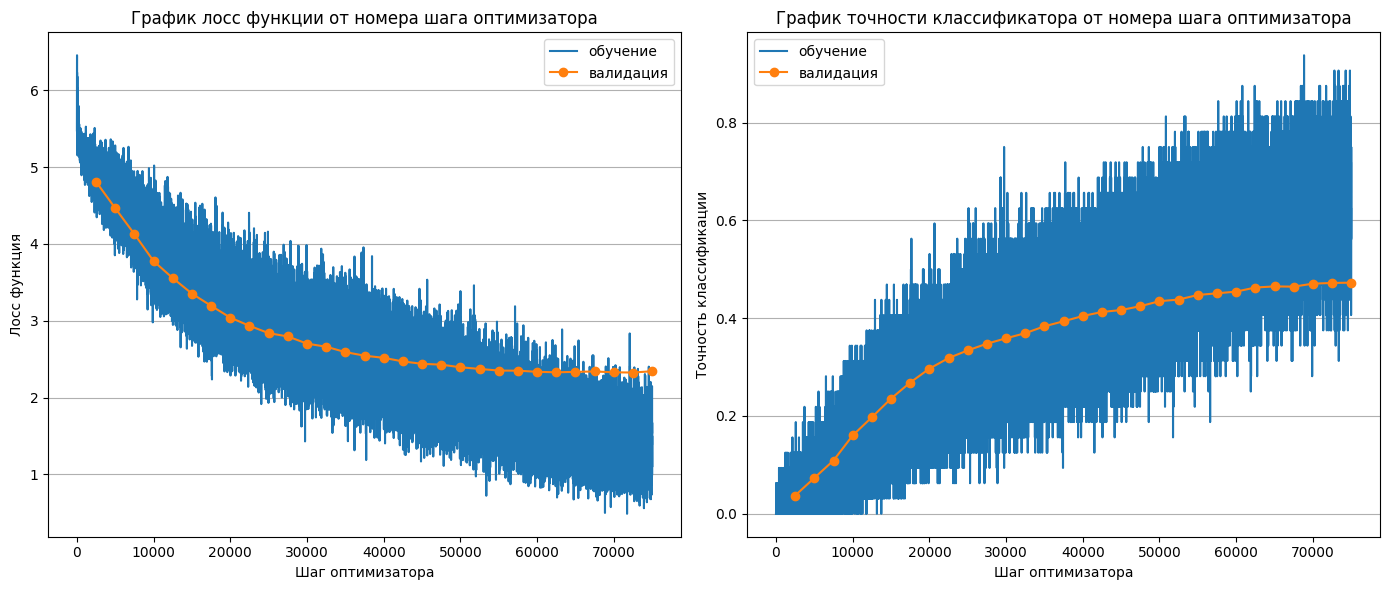

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (14, 6))

ax[0].plot(train_loss_log, label = "обучение")
ax[0].plot((torch.arange(len(val_loss_log)) + 1) * len(train_loader), val_loss_log, label = "валидация", marker = "o")
ax[0].set_xlabel("Шаг оптимизатора")
ax[0].set_ylabel("Лосс функция")
ax[0].set_title("График лосс функции от номера шага оптимизатора")
ax[0].grid(axis = "y")
ax[0].legend()


ax[1].plot(train_acc_log, label = "обучение")
ax[1].plot((torch.arange(len(val_acc_log)) + 1) * len(train_loader), val_acc_log, label = "валидация", marker = "o")
ax[1].set_xlabel("Шаг оптимизатора")
ax[1].set_ylabel("Точность классификации")
ax[1].set_title("График точности классификатора от номера шага оптимизатора")
ax[1].grid(axis = "y")
ax[1].legend()

plt.tight_layout()
plt.show()

In [13]:
# net = torch.load("checkpoint.pth", weights_only=False)
# net = net.to(device)
# net.eval()

Test Time Augmentation

In [14]:
files = [file for file in os.listdir("test")]

pred = []

with torch.no_grad():
    for i in tqdm.tqdm(range(len(files))):
        file = files[i]
        transform = v2.Normalize((128, 128, 128), (128, 128, 128))
        augmentations = transforms.Compose([
            v2.RandomHorizontalFlip(),
            transforms.RandomApply([v2.RandomAffine(degrees=0, translate=(1/8,1/8))], p=0.6),
        ])
        img = torchvision.io.read_image(f"test/{file}").to(torch.float).to(device)
        img = transform(img)
        res = []
        for i in range(5):
            logits = net(augmentations(img).unsqueeze(0))[0]
            res.append(int(logits.argmax().to("cpu")))
        
        pred.append(max(res, key=lambda x: res.count(x)))


100%|██████████| 10000/10000 [16:48<00:00,  9.92it/s]


Simple testing

In [15]:
# files = [file for file in os.listdir("test")]

# pred = []

# with torch.no_grad():
#     for i in tqdm.tqdm(range(len(files))):
#         file = files[i]
#         transform = v2.Normalize((128, 128, 128), (128, 128, 128))
#         img = torchvision.io.read_image(f"test/{file}").to(torch.float).to(device)
#         img = transform(img)
#         logits = net(img.unsqueeze(0))[0]
#         pred.append(int(logits.argmax().to("cpu")))

In [16]:
data = {
    "Id" : files,
    "Category" : pred
}

df = pd.DataFrame(data)

In [17]:
df.to_csv("labels_test.csv", index=False)